## Time to get your hands dirty. Black-hole binary formation channels with gaussian mixtures.

Many problems in astrophysics give rise to data with multiple modes. This is typically because different processes physical processes contribute to the observed dataset. 

For instance, one of the most outstanding question in gravitational-wave astrophysics is the formation channel of binary black holes. Leading scenarions include the evolution of isolated binaries in the galactic field and the dynamica assembly of sources in dense environments like globular clusters.


Right now, state-of-the-art analyses seems to say that many channels are all at play. This is a plot by [Zevin et al (2020)](https://arxiv.org/abs/2011.10057)


Some events form in different astrophysical environments than others. **You want to figure out how many of formation channels are at play.**


The strategy here is to fit a Gaussian Mixture model: that is, my model is a sum of $N$ gaussians each with mean $\mu_j$ and standard deviation $\sigma_j$ and weight $\alpha_j$:

$p(x_i|\theta) = \sum_{j=1}^N \alpha_j \mathcal{N}(\mu_j,\sigma_j) $

This depends on $3N-1$ parameters (not $3N$ because the sum of the $\alpha_j$ must be unity to ensure that this is a probability.

#### Tasks

1) Load this file (`np.load`) and complete a quick exploration of the data. How many modes do you think you see?

2) We'll use `sklearn.mixture.GaussianMixture`. You first need to define the model (instance of a class), and then train it on the data using the `fit` method (the data provided are already in the right numpy format!). This will output the trained model, which has various attributes.

*Note*. We'll do a more formal introduction to scikit-learn in one of the next lectures. Today's exercise is meant to be a formative example on how you might find yourself dealing with a library you've never seen before. This happens *all the time* in research...

3) Complete the fit 10 times with $N=1,...,10$ Gaussians. 

Note: `sklearn` by default will use the so-called [Expectation-Maximization algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm), which is one of the many great things in data science we don't have time to study in this class.

4) For each of this fits, compute the AIC (easy! It's an attribute of the trained model!). Plot $N$ vs AIC: which model is preferred?

5) Plot the preferred solution on top of the input data. You should get a very nice fit!


---



# Black hole data analysis
## Data Loading

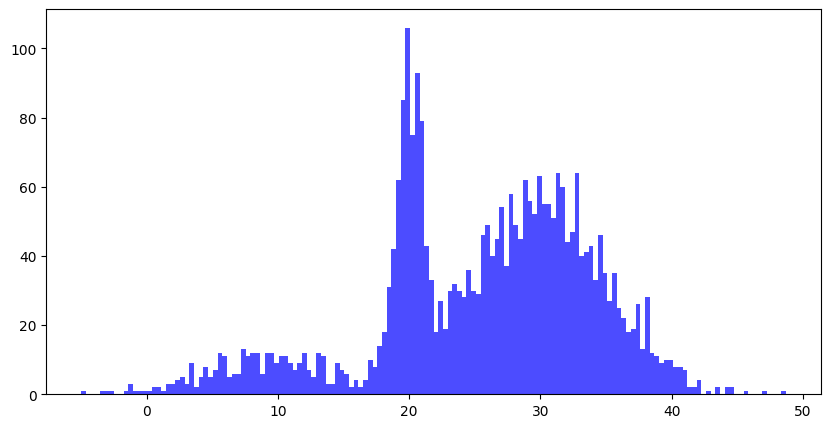

In [1]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load('formationchannels.npy')

plt.figure(figsize=(10, 5))
plt.hist(data, bins=150, color='blue', alpha=0.7)
plt.show()

## Dataset fit with multiple normal distribution
We want to fit the dataset with a function like:
$$
p(x| \vec{\mu}, \vec{\sigma}, \vec{\alpha}) = \sum_{j = 1}^N \alpha_j \mathcal{N}(x| \mu_j, \sigma_j)
$$
Take a look at the dataset we can suppose that $N = 3$. To perform the fit we use the method `fit` from the class `sklearn.mixture.GaussianMixture`.

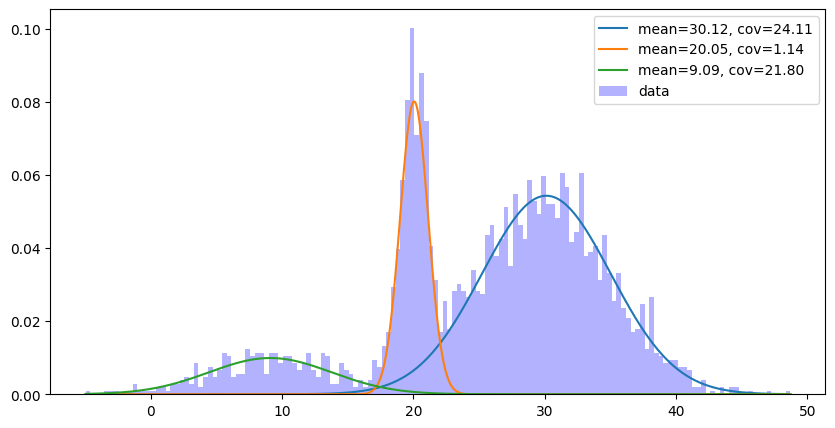

In [ ]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=0)
# We initialize the random state to 0 to ensure reproducibility
gmm.fit(data)

# plot data and the three distributions
plt.figure(figsize=(10, 5))
x = np.linspace(np.min(data), np.max(data), 1000)
for i in range(gmm.n_components):
    # We study the first elements (0) because we are in 1D
    mean = gmm.means_[i][0]
    cov = gmm.covariances_[i][0][0]
    plt.plot(x, gmm.weights_[i] * norm.pdf(x, mean, np.sqrt(cov)), label=f'mean={mean:.2f}, cov={cov:.2f}')
plt.hist(data, bins=150, density=True, color='blue', alpha=0.3, label='data')

plt.legend()
plt.show()

We can analize the fitted dataset with the method `predict_proba`, it return the probability of each data to be generated under a specific Gaussian of the mixture. 

If we have a dataset with $N$ samples and a **Gaussian Mixture Model (GMM)** with $K$ components.  
The `predict_proba` method returns an $N\times K$ matrix where:

- **Each row** represents a data point.  
- **Each column** represents a GMM component ($\alpha_k \mathcal{N}(x| \mu_k, \sigma_k)$).  
- **Each value in the matrix** is the probability that a given data point belongs to that component.  

Mathematically, for a sample, the method computes:
$$
p(k|x) = \frac{\alpha_k \mathcal{N}(x| \mu_k, \sigma_k)}{\sum_j \alpha_j \mathcal{N}(x| \mu_j, \sigma_j)}
$$

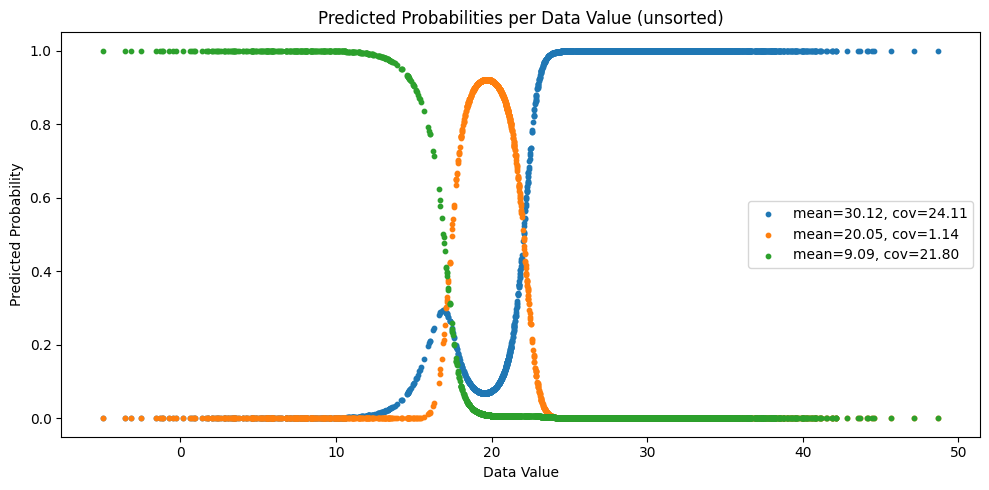

In [3]:
# Compute the predicted probabilities from the fitted GMM model
predict_proba = gmm.predict_proba(data)

# Create custom labels for each component using its mean and covariance.
# For one-dimensional data, the mean is at index [0] and covariance as [0][0].
labels = []
for i in range(gmm.n_components):
    mean_i = gmm.means_[i][0]
    cov_i = gmm.covariances_[i][0][0]
    labels.append(f"mean={mean_i:.2f}, cov={cov_i:.2f}")

plt.figure(figsize=(10, 5))
plt.scatter(data.ravel(), predict_proba[:, 0], label=labels[0], s=10, color='C0')
plt.scatter(data.ravel(), predict_proba[:, 1], label=labels[1], s=10, color='C1')
plt.scatter(data.ravel(), predict_proba[:, 2], label=labels[2], s=10, color='C2')

plt.xlabel("Data Value")
plt.ylabel("Predicted Probability")
plt.title("Predicted Probabilities per Data Value (unsorted)")
plt.legend()
plt.tight_layout()
plt.show()

We can also compute the **log-likelihood** for each point in the dataset using the method `score_samples`(while `score` compute the average log-likelihood of the dataset). 

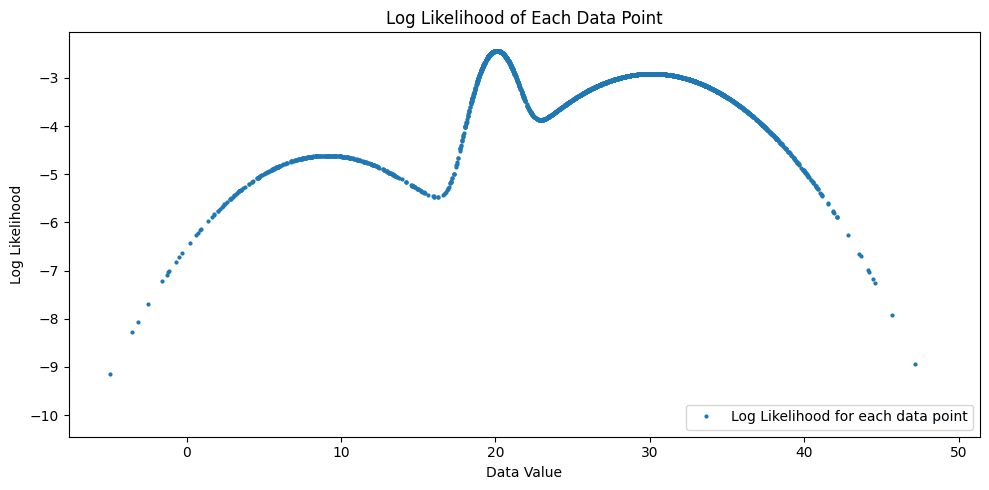

In [4]:
log_likelihood_points = gmm.score_samples(data)

plt.figure(figsize=(10, 5))
plt.plot(data, log_likelihood_points, 'o', markersize=2, label='Log Likelihood for each data point')
plt.xlabel("Data Value")
plt.ylabel("Log Likelihood")
plt.title("Log Likelihood of Each Data Point")
plt.tight_layout()
plt.legend(loc='lower right')
plt.show()

**Observation**: The maximum of the likelihood function extract the parameters to fit in the best way our dataset. So we can see the likelihood as the pdf that fit the data


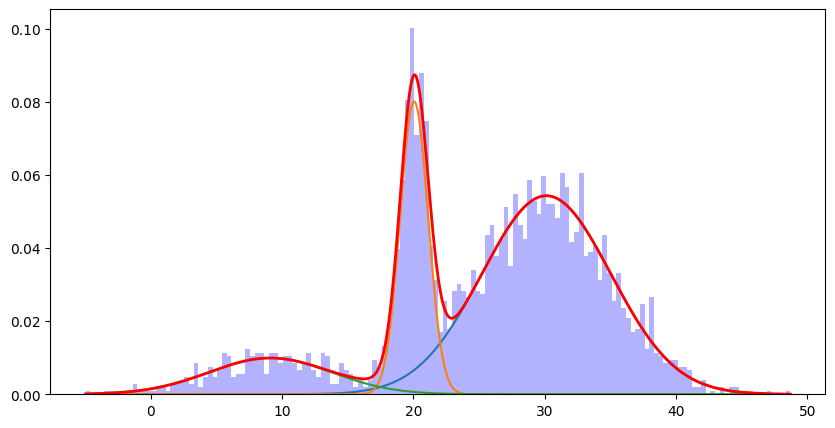

In [5]:
pdf = np.exp(log_likelihood_points)

plt.figure(figsize=(10, 5))
x = np.linspace(np.min(data), np.max(data), 1000)
for i in range(gmm.n_components):
    mean = gmm.means_[i][0]
    cov = gmm.covariances_[i][0][0]
    plt.plot(x, gmm.weights_[i] * norm.pdf(x, mean, np.sqrt(cov)), label=f'mean={mean:.2f}, cov={cov:.2f}')
plt.hist(data, bins=150, density=True, color='blue', alpha=0.3, label='data')

sort_idx = np.argsort(data.ravel())
x_sorted = data.ravel()[sort_idx]
pdf_sorted = pdf[sort_idx]
plt.plot(x_sorted, pdf_sorted, '-', linewidth=2, label='PDF', color='red')

### Different fit changing $N$

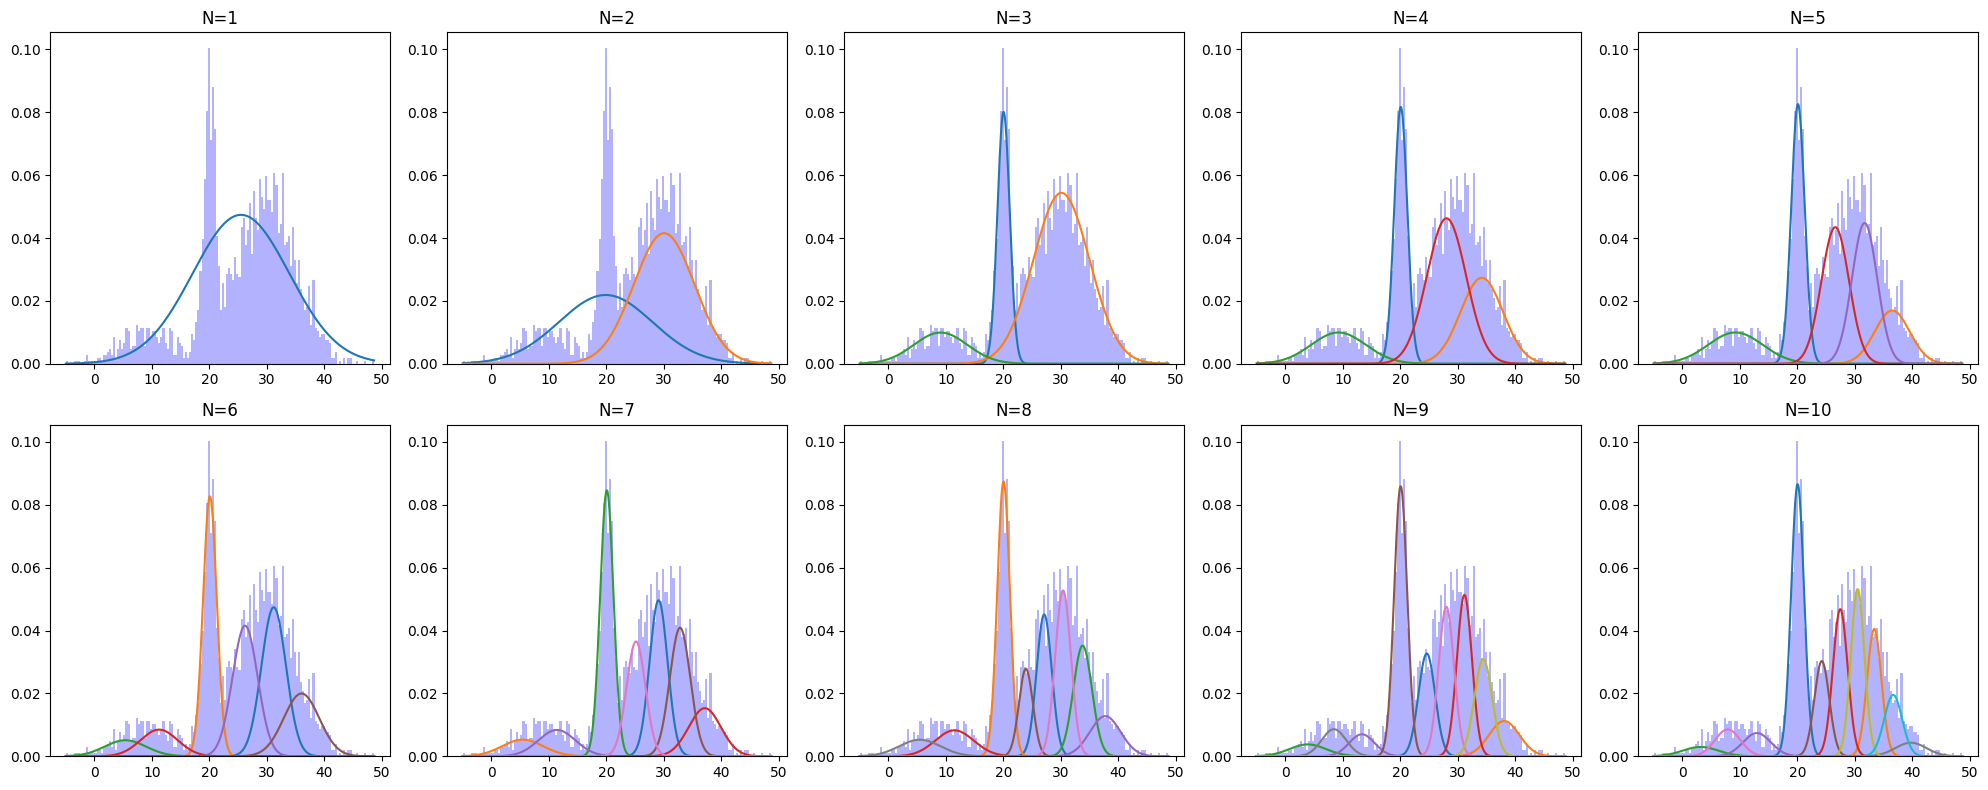

In [ ]:
gmms = []
for n in range(1, 11):
    gmm = GaussianMixture(n_components=n, covariance_type='full')
    gmm.fit(data)
    gmms.append(gmm)

# plot all the GMMS in 10 subplots in 1 figure
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, gmm in enumerate(gmms):
    ax = axs[i // 5, i % 5]
    x = np.linspace(np.min(data), np.max(data), 1000)
    for j in range(gmm.n_components):
        mean = gmm.means_[j][0]  
        cov = gmm.covariances_[j][0][0]
        ax.plot(x, gmm.weights_[j] * norm.pdf(x, mean, np.sqrt(cov)), label=f'mean={mean:.2f}, cov={cov:.2f}')
    ax.hist(data, bins=150, density=True, color='blue', alpha=0.3, label='data')
    ax.set_title(f'N={gmm.n_components}')
    # ax.legend()
plt.tight_layout()
plt.show()

To find the best fit we can use a popular general-purpose tool for model comparison, the **Akaike Information Criterion** (AIC):

$$ 
\mathrm{AIC}_M \equiv -2\ln[\mathcal{L}^0(M)] + 2k + \frac{2k(k+1)}{N-k-1}
$$

where $\mathcal{L}^0$ is the **maximum of the likelihood distribution**, $k$ is the number of model parameters and $N$ is the number of data points. 

The model with lowest AIC is the most favored.
If all models are equally successful at fitting the data (equal $\mathcal{L}^0$ values) then the second and third terms penalize model complexity such that the model with fewest free parameters wins. 

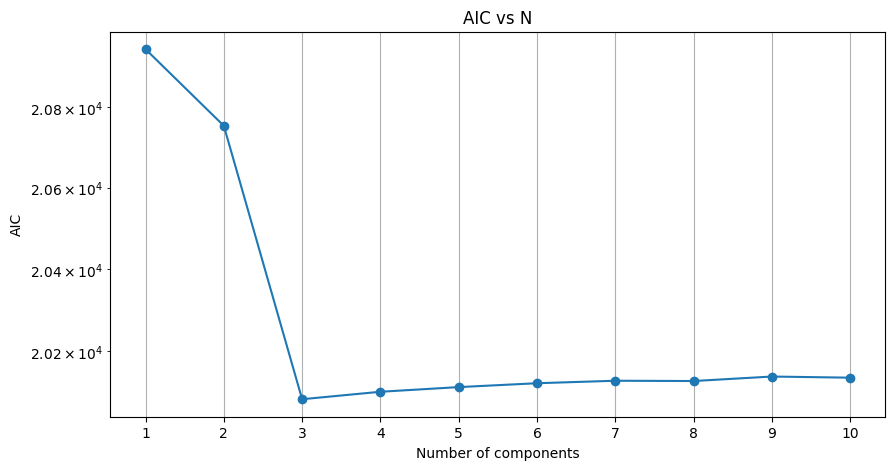

In [8]:
# Compute and plot AIC vs N
aic = []
for gmm in gmms:
    aic.append(gmm.aic(data))

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), aic, marker='o')
plt.title('AIC vs N')
plt.xlabel('Number of components')
plt.ylabel('AIC')
plt.yscale('log')
plt.xticks(range(1, 11))
plt.grid()
plt.show()


Fortunatly we can see that the best model is the one with 3 normal distribution, analized before.